In [ ]:
# !pip install --upgrade pandas matplolib opencv-python imutils seaborn tqdm bounding-box --quiet

In [1]:
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [54]:
from imutils import paths
import pathlib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import shutil
import re
import xml.etree.ElementTree as ET
from tqdm.auto import tqdm
from bounding_box import bounding_box as bb
import numpy as np

sns.set()
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_rows', None)

In [3]:
DATA_DIR = pathlib.Path("../../Datasets/oxford-iiit-pet/")
list(DATA_DIR.iterdir())

[PosixPath('../../Datasets/oxford-iiit-pet/.DS_Store'),
 PosixPath('../../Datasets/oxford-iiit-pet/images'),
 PosixPath('../../Datasets/oxford-iiit-pet/annotations')]

In [4]:
image_dir = DATA_DIR/"images"
annot_dir = DATA_DIR/"annotations/xmls"

list(image_dir.iterdir())[:3], list(annot_dir.iterdir())[:3]

([PosixPath('../../Datasets/oxford-iiit-pet/images/Egyptian_Mau_167.jpg'),
  PosixPath('../../Datasets/oxford-iiit-pet/images/pug_52.jpg'),
  PosixPath('../../Datasets/oxford-iiit-pet/images/basset_hound_112.jpg')],
 [PosixPath('../../Datasets/oxford-iiit-pet/annotations/xmls/British_Shorthair_10.xml'),
  PosixPath('../../Datasets/oxford-iiit-pet/annotations/xmls/german_shorthaired_119.xml'),
  PosixPath('../../Datasets/oxford-iiit-pet/annotations/xmls/english_setter_158.xml')])

In [5]:
image_list = list(image_dir.iterdir())
image_list = [str(i) for i in image_list]

annot_list = list(annot_dir.iterdir())
annot_list = [str(a) for a in annot_list]

image_list[:5], annot_list[:5]

(['../../Datasets/oxford-iiit-pet/images/Egyptian_Mau_167.jpg',
  '../../Datasets/oxford-iiit-pet/images/pug_52.jpg',
  '../../Datasets/oxford-iiit-pet/images/basset_hound_112.jpg',
  '../../Datasets/oxford-iiit-pet/images/Siamese_193.jpg',
  '../../Datasets/oxford-iiit-pet/images/shiba_inu_122.jpg'],
 ['../../Datasets/oxford-iiit-pet/annotations/xmls/British_Shorthair_10.xml',
  '../../Datasets/oxford-iiit-pet/annotations/xmls/german_shorthaired_119.xml',
  '../../Datasets/oxford-iiit-pet/annotations/xmls/english_setter_158.xml',
  '../../Datasets/oxford-iiit-pet/annotations/xmls/Siamese_178.xml',
  '../../Datasets/oxford-iiit-pet/annotations/xmls/pomeranian_162.xml'])

In [6]:
print("Total no. of Image Files",len(image_list))
print("Total no. of Annotation Files",len(annot_list))

Total no. of Image Files 7393
Total no. of Annotation Files 3686


**NB: Not all `Images` have `Annotations`. We need to extract the ones that have annotations.**

In [7]:
! cat ../../Datasets/oxford-iiit-pet/annotations/xmls/British_Shorthair_10.xml

<annotation><folder>OXIIIT</folder><filename>British_Shorthair_10.jpg</filename><source><database>OXFORD-IIIT Pet Dataset</database><annotation>OXIIIT</annotation><image>flickr</image></source><size><width>233</width><height>350</height><depth>3</depth></size><segmented>0</segmented><object><name>cat</name><pose>Frontal</pose><truncated>0</truncated><occluded>0</occluded><bndbox><xmin>83</xmin><ymin>29</ymin><xmax>197</xmax><ymax>142</ymax></bndbox><difficult>0</difficult></object></annotation>


In [8]:
# From : https://github.com/datitran/raccoon_dataset/blob/master/xml_to_csv.py
def parse_xml(pths:list)->pd.DataFrame:
    im_list = []
    ann_list = []
    for xml_file in pths:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for m in root.findall("object"):
            try:
                fname = root.find("filename").text
                value = str(image_dir/fname)
                # append the image path
                im_list.append(value)
                # append the annotation path
                ann_list.append(xml_file)
            except:
                pass
    df = pd.DataFrame()
    df["image_path"] = im_list
    df["annot_path"] = ann_list
    return df

In [9]:
df = parse_xml(annot_list)
df.head()

image_path  \
0    ../../Datasets/oxford-iiit-pet/images/British_Shorthair_10.jpg   
1  ../../Datasets/oxford-iiit-pet/images/german_shorthaired_119.jpg   
2      ../../Datasets/oxford-iiit-pet/images/english_setter_158.jpg   
3             ../../Datasets/oxford-iiit-pet/images/Siamese_178.jpg   
4          ../../Datasets/oxford-iiit-pet/images/pomeranian_162.jpg   

                                                                   annot_path  
0    ../../Datasets/oxford-iiit-pet/annotations/xmls/British_Shorthair_10.xml  
1  ../../Datasets/oxford-iiit-pet/annotations/xmls/german_shorthaired_119.xml  
2      ../../Datasets/oxford-iiit-pet/annotations/xmls/english_setter_158.xml  
3             ../../Datasets/oxford-iiit-pet/annotations/xmls/Siamese_178.xml  
4          ../../Datasets/oxford-iiit-pet/annotations/xmls/pomeranian_162.xml

In [10]:
# Extract the class name from the filename

# Regular expression to extract the label from the path expression
pat = r'/([^/]+)_\d+.jpg$'
pat = re.compile(pat)

df["class"] = [pat.search(fname).group(1).lower() for fname in df["image_path"]]
# Wether cat or dog: [cat images has 1st character Upper Case]
df["cat_or_dog"] = ["cat" if df["image_path"][i].split(os.path.sep)[-1].split(".")[0][0].isupper()
                    else "dog" for i in range(len(df))]

In [11]:
df.head(10)

image_path  \
0    ../../Datasets/oxford-iiit-pet/images/British_Shorthair_10.jpg   
1  ../../Datasets/oxford-iiit-pet/images/german_shorthaired_119.jpg   
2      ../../Datasets/oxford-iiit-pet/images/english_setter_158.jpg   
3             ../../Datasets/oxford-iiit-pet/images/Siamese_178.jpg   
4          ../../Datasets/oxford-iiit-pet/images/pomeranian_162.jpg   
5        ../../Datasets/oxford-iiit-pet/images/newfoundland_137.jpg   
6             ../../Datasets/oxford-iiit-pet/images/Siamese_150.jpg   
7  ../../Datasets/oxford-iiit-pet/images/german_shorthaired_131.jpg   
8      ../../Datasets/oxford-iiit-pet/images/english_setter_170.jpg   
9      ../../Datasets/oxford-iiit-pet/images/english_setter_164.jpg   

                                                                   annot_path  \
0    ../../Datasets/oxford-iiit-pet/annotations/xmls/British_Shorthair_10.xml   
1  ../../Datasets/oxford-iiit-pet/annotations/xmls/german_shorthaired_119.xml   
2      ../../Datasets/oxford-iiit-pet/annotations/xmls/english_setter_158.xml   
3             ../../Datasets/oxford-iiit-pet/annotations/xmls/Siamese_178.xml   
4          ../../Datasets/oxford-iiit-pet/annotations/xmls/pomeranian_162.xml   
5        ../../Datasets/oxford-iiit-pet/annotations/xmls/newfoundland_137.xml   
6             ../../Datasets/oxford-iiit-pet/annotations/xmls/Siamese_150.xml   
7  ../../Datasets/oxford-iiit-pet/annotations/xmls/german_shorthaired_131.xml   
8      ../../Datasets/oxford-iiit-pet/annotations/xmls/english_setter_170.xml   
9      ../../Datasets/oxford-iiit-pet/annotations/xmls/english_setter_164.xml   

                class cat_or_dog  
0   british_shorthair        cat  
1  german_shorthaired        dog  
2      english_setter        dog  
3             siamese        cat  
4          pomeranian        dog  
5        newfoundland        dog  
6             siamese        cat  
7  german_shorthaired        dog  
8      english_setter        dog  
9      english_setter        dog

In [12]:
df_dogs = df.loc[df.cat_or_dog == "dog"]
df_cats = df.loc[df.cat_or_dog == "cat"]

In [13]:
print("Number of unique dog breeds: ",len(df_dogs['class'].unique())) 
print("Number of unique cat breeds: ",len(df_cats['class'].unique()))

Number of unique dog breeds:  25
Number of unique cat breeds:  12


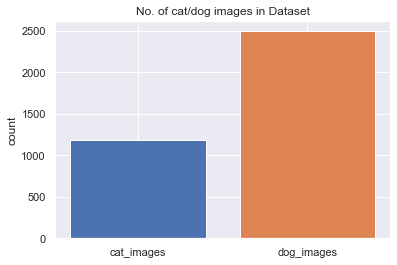

In [14]:
plt.bar(x="cat_images", height=len(df_cats))
plt.bar(x="dog_images", height=len(df_dogs))
plt.title("No. of cat/dog images in Dataset")
plt.ylabel("count");

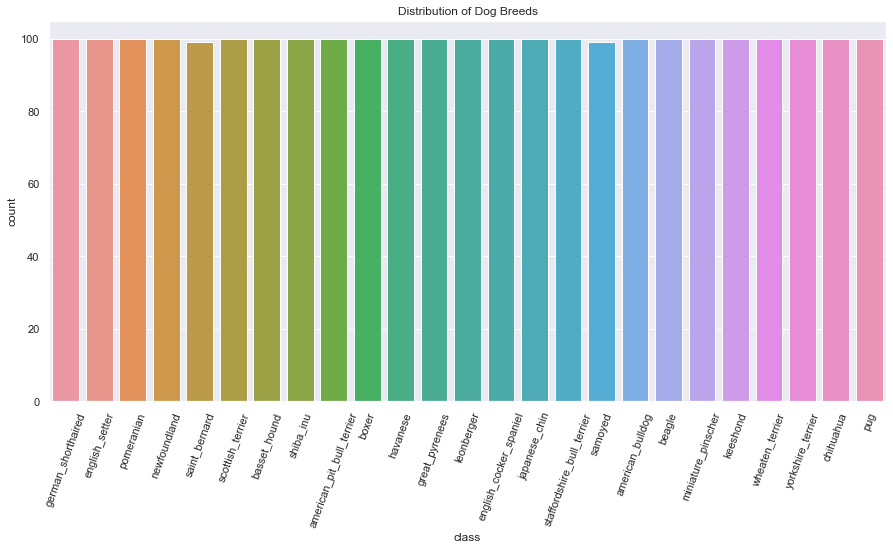

In [15]:
_, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.countplot(x="class", data=df_dogs, ax=ax)
ax.set_title("Distribution of Dog Breeds")
plt.xticks(rotation=70);

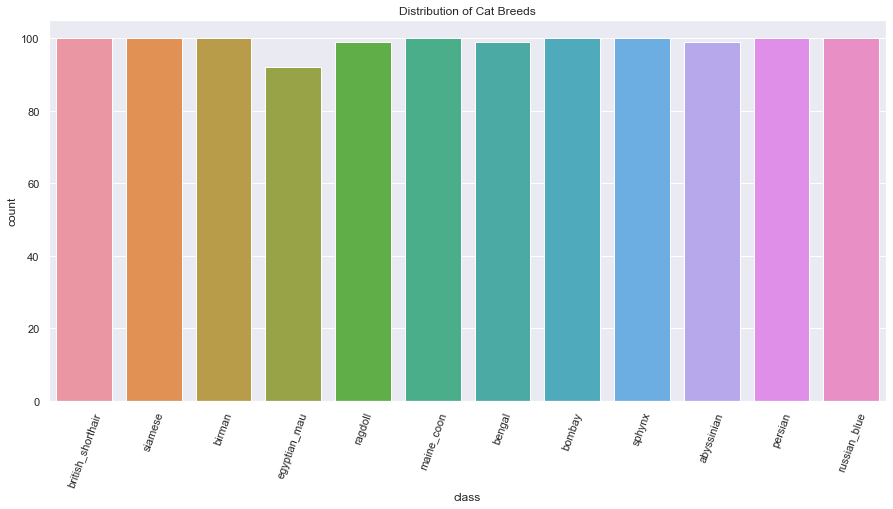

In [16]:
_, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.countplot(x="class", data=df_cats, ax=ax)
ax.set_title("Distribution of Cat Breeds")
plt.xticks(rotation=70);

In [17]:
df.head()

image_path  \
0    ../../Datasets/oxford-iiit-pet/images/British_Shorthair_10.jpg   
1  ../../Datasets/oxford-iiit-pet/images/german_shorthaired_119.jpg   
2      ../../Datasets/oxford-iiit-pet/images/english_setter_158.jpg   
3             ../../Datasets/oxford-iiit-pet/images/Siamese_178.jpg   
4          ../../Datasets/oxford-iiit-pet/images/pomeranian_162.jpg   

                                                                   annot_path  \
0    ../../Datasets/oxford-iiit-pet/annotations/xmls/British_Shorthair_10.xml   
1  ../../Datasets/oxford-iiit-pet/annotations/xmls/german_shorthaired_119.xml   
2      ../../Datasets/oxford-iiit-pet/annotations/xmls/english_setter_158.xml   
3             ../../Datasets/oxford-iiit-pet/annotations/xmls/Siamese_178.xml   
4          ../../Datasets/oxford-iiit-pet/annotations/xmls/pomeranian_162.xml   

                class cat_or_dog  
0   british_shorthair        cat  
1  german_shorthaired        dog  
2      english_setter        dog  
3             siamese        cat  
4          pomeranian        dog

In [28]:
os.makedirs("../Data", exist_ok=True)
os.makedirs("../Data/Images", exist_ok=True)
os.makedirs("../Data/Annotations", exist_ok=True)

IMG_DIR = "../Data/Images"
ANNOT_DIR = "../Data/Annotations/"

In [30]:
for i, image_path in enumerate(tqdm(df["image_path"].values)):
    # copy the images
    IMG_DEST = os.path.join(IMG_DIR, df["class"][i])
    os.makedirs(IMG_DEST, exist_ok=True)
    shutil.copy2(image_path, IMG_DEST)
    # copy the annotations
    ANNOT_SRC = df["annot_path"][i]
    shutil.copy2(ANNOT_SRC, ANNOT_DIR)
#     print(image_path)
#     print(IMG_DEST)
#     print(ANNOT_SRC)
#     print(ANNOT_DIR)

In [34]:
ANNOT_LIST = list(pathlib.Path("../Data/Annotations").iterdir())
ANNOT_LIST = [str(a) for a in ANNOT_LIST]
ANNOT_LIST[:5]

['../Data/Annotations/British_Shorthair_10.xml',
 '../Data/Annotations/german_shorthaired_119.xml',
 '../Data/Annotations/english_setter_158.xml',
 '../Data/Annotations/Siamese_178.xml',
 '../Data/Annotations/pomeranian_162.xml']

In [46]:
# From : https://github.com/datitran/raccoon_dataset/blob/master/xml_to_csv.py

def create_dataframe(pths:list)->pd.DataFrame:
    '''Parse given xml files & create a DataFrame out of it'''
    vals = []
    for xml_file in pths:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for m in root.findall("object"):
            try:
                # 1. Filename
                fname = root.find("filename").text
                # path of the image [original]
                orig_pth = str(image_dir/fname)
                # extract the class name from the original path
                class_name = pat.search(orig_pth).group(1).lower()
                # new path
                path = f"{IMG_DIR}/{class_name}/{fname}"
                
                # 2. Class Name
                class_name = class_name
                
                # 3. Height & Width of the bbox
                h = float(root.find('size')[0].text)
                w = float(root.find('size')[1].text)
                
                # 4. Extract the Bounding Boxes
                xmin = float(m[4][0].text)
                ymin = float(m[4][1].text)
                xmax = float(m[4][2].text)
                ymax = float(m[4][3].text)
                
                values = (path, class_name, h, w, xmin, ymin, xmax, ymax)
                # append the values to vals
                vals.append(values)
            except:
                pass
    columns = ["fname", "class_name", "height", "width", "xmin", "ymin", "xmax", "ymax"]
    df = pd.DataFrame(vals, columns=columns)
    return df

In [52]:
df = create_dataframe(ANNOT_LIST)
df.to_csv("../Data/Images.csv")
df.head()

fname  \
0     ../Data/Images/british_shorthair/British_Shorthair_10.jpg   
1  ../Data/Images/german_shorthaired/german_shorthaired_119.jpg   
2          ../Data/Images/english_setter/english_setter_158.jpg   
3                        ../Data/Images/siamese/Siamese_178.jpg   
4                  ../Data/Images/pomeranian/pomeranian_162.jpg   

           class_name  height  width   xmin  ymin   xmax   ymax  
0   british_shorthair   233.0  350.0   83.0  29.0  197.0  142.0  
1  german_shorthaired   500.0  500.0  128.0  22.0  240.0  222.0  
2      english_setter   333.0  500.0   97.0  35.0  304.0  199.0  
3             siamese   500.0  400.0   32.0  18.0  363.0  369.0  
4          pomeranian   222.0  300.0   19.0  32.0  123.0  129.0

In [69]:
def view_random_image(ax=None, color:str=None)->None:
    """displays a random Image from the Dataset"""
    idx = np.random.randint(0, len(df))
    im_df = df.loc[df.fname == df.fname[idx]]
    im_df.reset_index(drop=True, inplace=True)
    # load in the Image
    im = cv2.imread(im_df.fname[0])
    # add bboxes
    for n in range(len(im_df)):
        # extract the co-ordinates
        class_name = im_df["class_name"][n]
        xmin,ymin,xmax,ymax = im_df['xmin'][n], im_df['ymin'][n], im_df['xmax'][n], im_df['ymax'][n]
        bb.add(im, xmin, ymin, xmax, ymax, label=class_name, color=color)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,8))
    ax.set_title(f"Fname: {im_df['fname'][0].split(os.path.sep)[-1].split('.')[0]}")
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.axis("off");

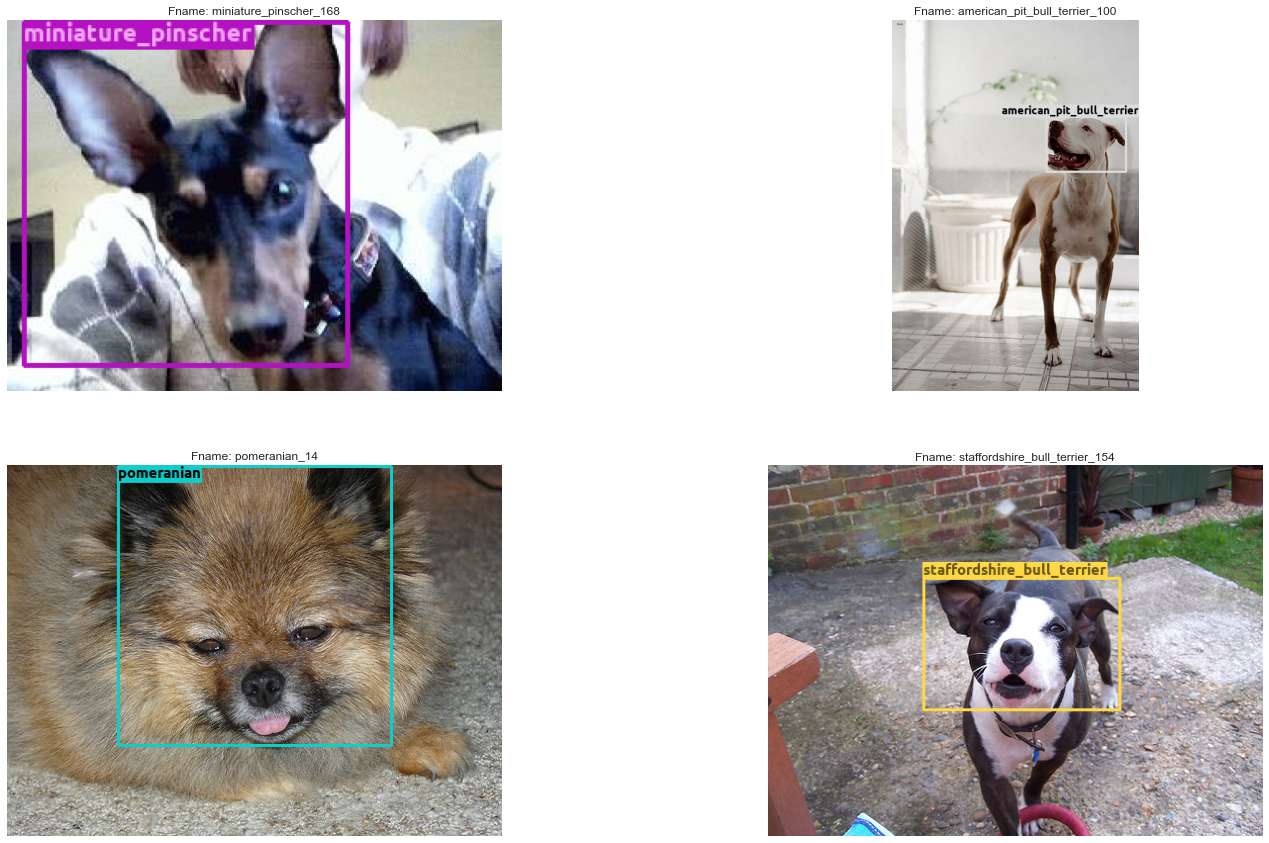

In [70]:
# Let's view some images
_ , ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15))
view_random_image(ax=ax1)
view_random_image(ax=ax2)
view_random_image(ax=ax3)
view_random_image(ax=ax4)

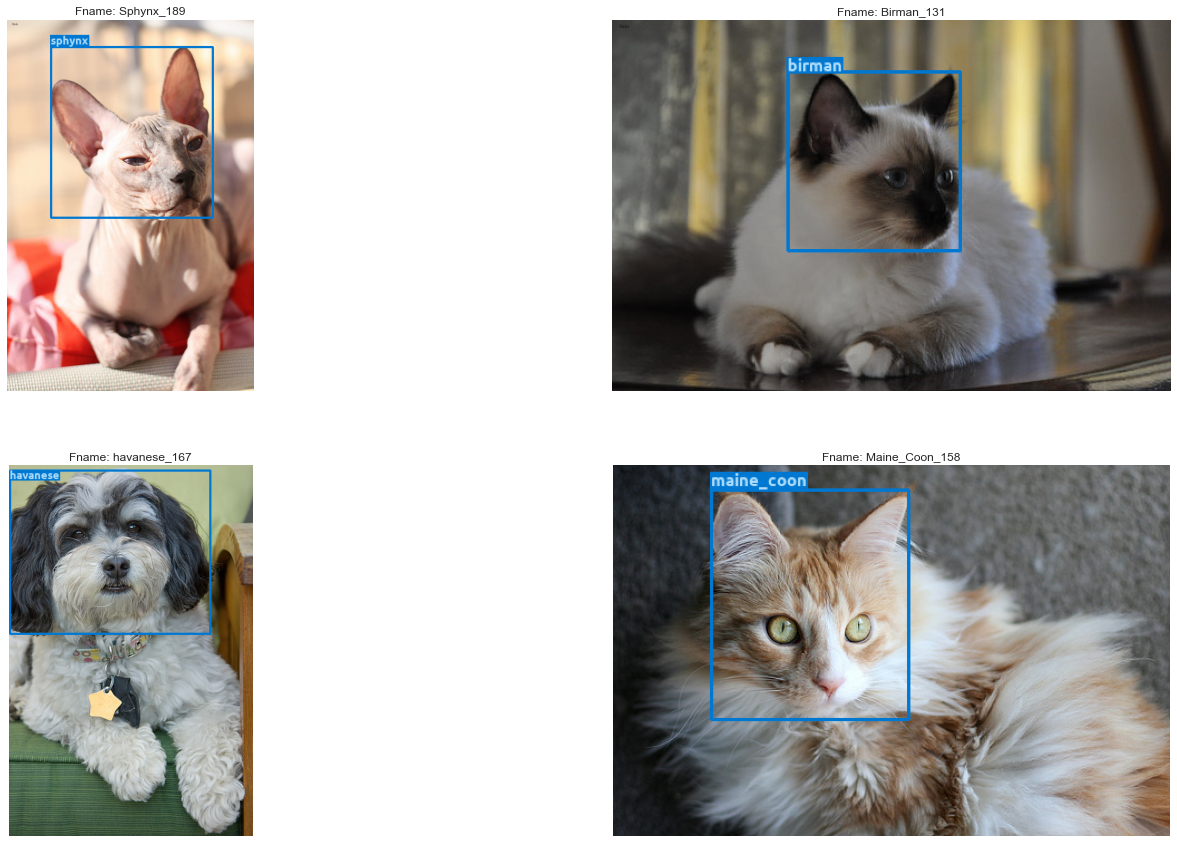

In [74]:
# Let's view some images
_ , ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15))
view_random_image(ax=ax1, color="blue")
view_random_image(ax=ax2, color="blue")
view_random_image(ax=ax3, color="blue")
view_random_image(ax=ax4, color="blue")

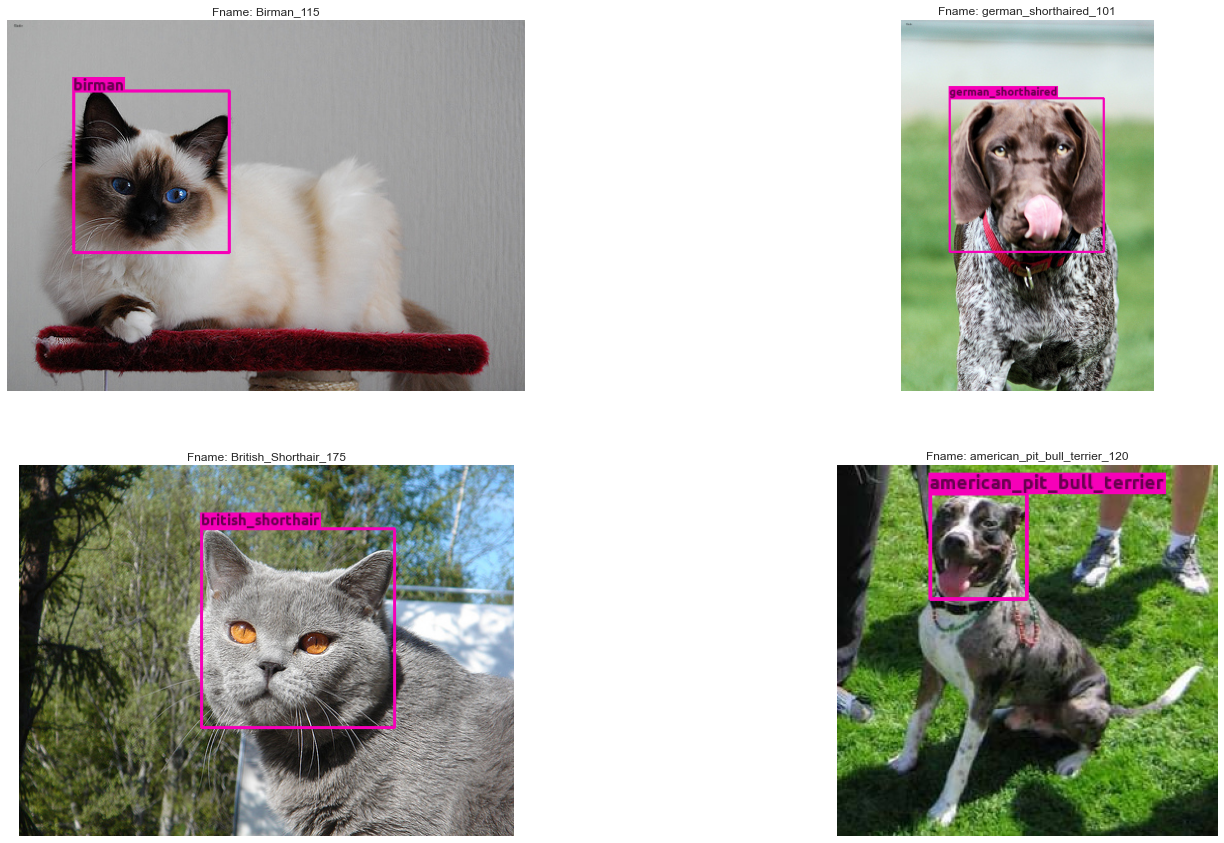

In [76]:
# Let's view some images
_ , ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15))
view_random_image(ax=ax1, color="fuchsia")
view_random_image(ax=ax2, color="fuchsia")
view_random_image(ax=ax3, color="fuchsia")
view_random_image(ax=ax4, color="fuchsia")